# Analyse des attaquants — KPIs, méthodes, visualisations
Notebook analytique basé sur FBref (Big‑5, 2024‑25) et colonnes personnalisées.

## 0. Chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 150)
df = pd.read_csv(r"../normalized_data/assembled_data_FW_normalized.csv")
df.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MainPos,MP,Starts,Min,90s,CrdY,CrdR,Gls,Sh_shooting,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK_shooting,xG,npxG,xG_shooting,npxG_shooting,npxG/Sh,G-xG,np:G-xG,PK,PKatt,Ast,KP,xAG,xA,A-xAG,PPA,CrsPA,Touches,Att 3rd_possession,Att Pen,Att_possession,Succ,Succ%,Tkld,Tkld%,Carries,PrgC,PrgDist_possession,CPA,Mis,Dis,PrgR,PrgC_possession,1/3_possession,Cmp,Att_passing,Cmp%,PrgP,Fls,Fld,Recov,Won,Lost_misc,Won%,Min%,Compl,Subs,PPM,onG,onGA,+/-,+/-90,onxG,onxGA,xG+/-,xG+/-90,Rk_per_90,CrdY_per_90,CrdR_per_90,Gls_per_90,Sh_shooting_per_90,SoT_per_90,SoT%_per_90,Sh/90_per_90,SoT/90_per_90,G/Sh_per_90,G/SoT_per_90,Dist_per_90,FK_shooting_per_90,xG_per_90,npxG_per_90,xG_shooting_per_90,npxG_shooting_per_90,npxG/Sh_per_90,G-xG_per_90,np:G-xG_per_90,PK_per_90,PKatt_per_90,Ast_per_90,KP_per_90,xAG_per_90,xA_per_90,A-xAG_per_90,PPA_per_90,CrsPA_per_90,Touches_per_90,Att 3rd_possession_per_90,Att Pen_per_90,Att_possession_per_90,Succ_per_90,Succ%_per_90,Tkld_per_90,Tkld%_per_90,Carries_per_90,PrgC_per_90,PrgDist_possession_per_90,CPA_per_90,Mis_per_90,Dis_per_90,PrgR_per_90,PrgC_possession_per_90,1/3_possession_per_90,Cmp_per_90,Att_passing_per_90,Cmp%_per_90,PrgP_per_90,Fls_per_90,Fld_per_90,Recov_per_90,Won_per_90,Lost_misc_per_90,Won%_per_90,Min%_per_90,Compl_per_90,Subs_per_90,PPM_per_90,onG_per_90,onGA_per_90,+/-_per_90,+/-90_per_90,onxG_per_90,onxGA_per_90,xG+/-_per_90,xG+/-90_per_90
0,2415,Aaron Seydel,de GER,FW,Darmstadt 98,de Bundesliga,27.0,1996.0,FW,16,5,619,6.9,1,0,1,14.0,6.0,42.9,2.04,0.870,0.070,0.170,16.8,0.0,1.0,1.0,1.0,1.0,0.07,0.0,0.0,0,0,0,9,0.7,0.6,-0.7,1,0,283,128,31,11,3,27.3,7,63.6,123,7,117,3,26,12,35,7,3,110,190,57.90,10,9.0,7.0,14.0,45.0,31.0,59.20,20.20,2.0,11.0,0.500,6.0,15.0,-9.0,-1.31,5.7,13.5,-7.8,-1.14,351.130856,0.145396,0.0,0.145396,2.035541,0.872375,6.237480,0.296607,0.126494,0.010178,0.024717,2.442649,0.000000,0.145396,0.145396,0.145396,0.145396,0.010178,0.000000,0.000000,0.0,0.000000,0.0,1.308562,0.101777,0.087237,-0.101777,0.145396,0.000000,41.147011,18.610662,4.507270,1.599354,0.436187,3.969305,1.017771,9.247173,17.883683,1.017771,17.011309,0.436187,3.780291,1.744750,5.088853,1.017771,0.436187,15.993538,27.625202,8.418417,1.453958,1.308562,1.017771,2.035541,6.542811,4.507270,8.607431,2.936995,0.290792,1.599354,0.072698,0.872375,2.180937,-1.308562,-0.190468,0.828756,1.962843,-1.134087,-0.165751
1,835,Abde Ezzalzouli,ma MAR,FW,Betis,es La Liga,21.0,2001.0,FW,28,6,933,9.6,1,0,1,33.0,8.0,24.6,4.36,1.075,0.015,0.065,17.8,0.0,3.0,2.2,3.0,2.2,0.07,-2.0,-1.2,0,1,0,4,0.3,0.5,-0.3,9,1,518,271,60,50,21,46.0,23,48.0,300,57,1587,35,29,31,89,57,34,232,353,63.95,25,9.0,16.0,44.0,23.0,23.0,41.65,13.65,1.0,20.0,1.675,11.0,9.0,2.0,1.43,11.4,12.7,-1.3,-0.13,80.546624,0.096463,0.0,0.096463,3.183280,0.771704,2.372990,0.420579,0.103698,0.001447,0.006270,1.717042,0.000000,0.289389,0.212219,0.289389,0.212219,0.006752,-0.192926,-0.115756,0.0,0.096463,0.0,0.385852,0.028939,0.048232,-0.028939,0.868167,0.096463,49.967846,26.141479,5.787781,4.823151,2.025723,4.437299,2.218650,4.630225,28.938907,5.498392,153.086817,3.376206,2.797428,2.990354,8.585209,5.498392,3.279743,22.379421,34.051447,6.168810,2.411576,0.868167,1.543408,4.244373,2.218650,2.218650,4.017685,1.316720,0.096463,1.929260,0.161576,1.061093,0.868167,0.192926,0.137942,1.099678,1.225080,-0.125402,-0.012540
2,2202,Abde Rebbach,dz ALG,"FW,MF",Alavés,es La Liga,24.0,1998.0,FW,23,6,722,8.0,1,0,1,17.0,4.0,23.5,2.12,0.500,0.060,0.250,19.4,1.0,0.8,0.8,0.8,0.8,0.05,0.2,0.2,0,0,0,18,1.8,1.7,-1.8,6,3,343,198,36,28,10,35.7,16,57.1,180,34,763,18,28,12,78,34,15,124,225,55.10,14,13.0,10.0,31.0,7.0,13.0,35.00,21.10,0.0,17.0,0.700,5.0,6.0,-1.0,-0.12,7.5,6.8,0.7,0.09,274.487535,0.124654,0.0,0.124654,2.119114,0.498615,2.929363,0.264266,0.062327,0.007479,0.031163,2.418283,0.124654,0.099723,0.099723,0.099723,0.099723,0.006233,0.024931,0.024931,0.0,0.000000,0.0,2.243767,0.224377,0.211911,-0.224377,0.747922,0.373961,42.756233,24.681440,4.487535,3.490305,1.

## 1. Audit du CSV et filtrage de stabilité
On applique un seuil de 600 minutes pour limiter le bruit.

In [2]:
df = df.copy()
df['minutes'] = df['90s'] * 90
base = df[df['minutes'] >= 600].copy()
base.shape

(392, 149)

In [3]:
def bar_top(df_in, col, n=15, title=None):
    t = df_in[['Player', col]].dropna().sort_values(col, ascending=False).head(n)
    fig, ax = plt.subplots(figsize=(9,6))
    ax.bar(t['Player'], t[col])
    ax.set_title(title or col)
    ax.set_xticklabels(t['Player'], rotation=75, ha='right')
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

def hist_plot(series, title=None, bins=20):
    s = series.dropna()
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(s, bins=bins)
    ax.set_title(title or series.name)
    ax.set_xlabel(series.name)
    ax.set_ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

### KPI : npG/90
**Pourquoi**: Mesure la finition hors pénalty. Compare des finisseurs sans inflation liée aux pénos.

**Formule**: `npG/90 = (Gls − PK) / 90s`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


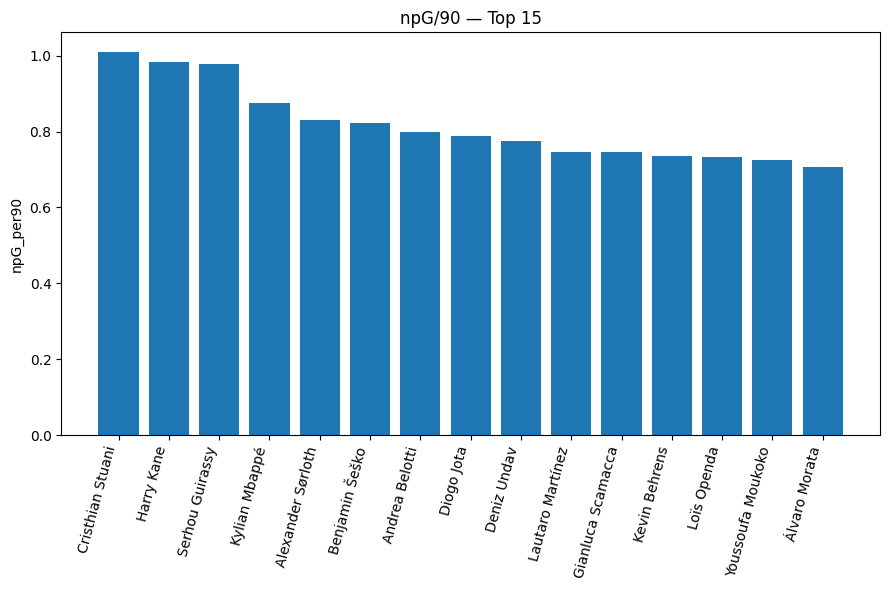

,Player,Squad,Comp,npG_per90
105,Cristhian Stuani,Girona,es La Liga,1.011236
197,Harry Kane,Bayern Munich,de Bundesliga,0.984127
471,Serhou Guirassy,Stuttgart,de Bundesliga,0.979592
287,Kylian Mbappé,Paris S-G,fr Ligue 1,0.875000
23,Alexander Sørloth,Villarreal,es La Liga,0.830325
67,Benjamin Šeško,RB Leipzig,de Bundesliga,0.823529
34,Andrea Belotti,Roma,it Serie A,0.800000
127,Diogo Jota,Liverpool,eng Premier League,0.787402
123,Deniz Undav,Stuttgart,de Bundesliga,0.775862
293,Lautaro Martínez,Inter,it Serie A,0.745763


In [4]:
base['npG'] = base['Gls'] - base.get('PK', 0)
base['npG_per90'] = base['npG'] / base['90s']
bar_top(base, 'npG_per90', title='npG/90 — Top 15')
base[['Player','Squad','Comp','npG_per90']].sort_values('npG_per90', ascending=False).head(10)

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Finishing_Delta_np
**Pourquoi**: Sur/sous-performance de finition vs attentes.

**Formule**: `Δ = (Gls − PK) − npxG`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


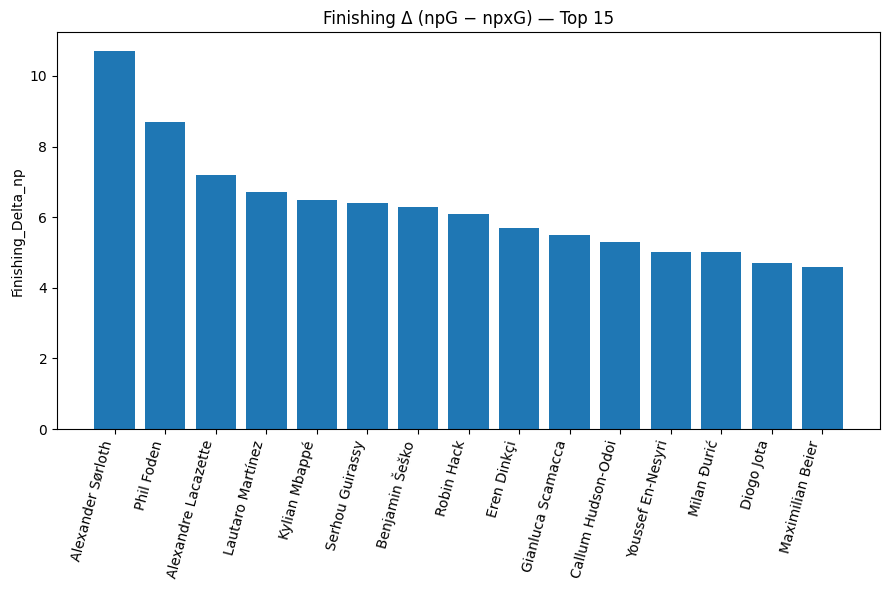

,Player,Squad,Comp,Finishing_Delta_np
23,Alexander Sørloth,Villarreal,es La Liga,10.7
416,Phil Foden,Manchester City,eng Premier League,8.7
24,Alexandre Lacazette,Lyon,fr Ligue 1,7.2
293,Lautaro Martínez,Inter,it Serie A,6.7
287,Kylian Mbappé,Paris S-G,fr Ligue 1,6.5
471,Serhou Guirassy,Stuttgart,de Bundesliga,6.4
67,Benjamin Šeško,RB Leipzig,de Bundesliga,6.3
445,Robin Hack,Gladbach,de Bundesliga,6.1
149,Eren Dinkçi,Heidenheim,de Bundesliga,5.7
184,Gianluca Scamacca,Atalanta,it Serie A,5.5


In [5]:
base['npG'] = base['Gls'] - base.get('PK', 0)
base['Finishing_Delta_np'] = base['npG'] - base['npxG']
bar_top(base, 'Finishing_Delta_np', title='Finishing Δ (npG − npxG) — Top 15')
base[['Player','Squad','Comp','Finishing_Delta_np']].sort_values('Finishing_Delta_np', ascending=False).head(10)

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Finishing_Ratio_np
**Pourquoi**: Étalonne l’écart de finition par la difficulté des tirs.

**Formule**: `Ratio = (Gls − PK) / npxG`

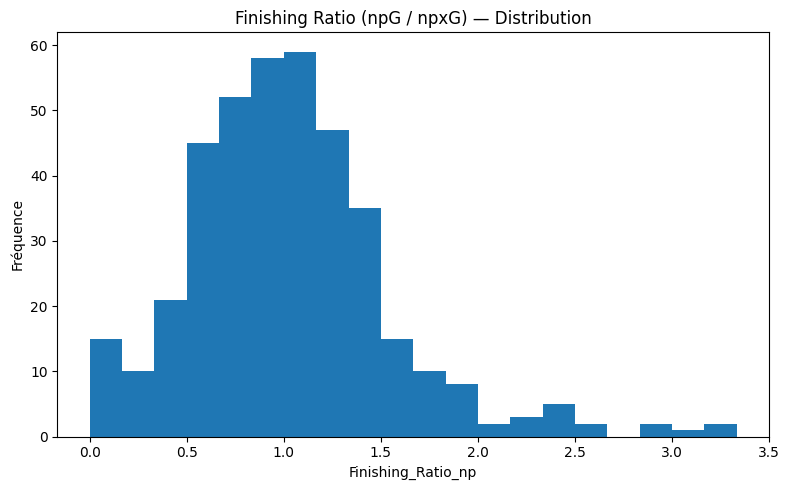

,Player,Squad,Comp,Finishing_Ratio_np
132,Domingos André Ribeiro Almeida,Valencia,es La Liga,3.333333
242,Joel Asoro,Metz,fr Ligue 1,3.333333
278,Kevin Behrens,Wolfsburg,de Bundesliga,3.125000
464,Saïd Benrahma,West Ham,eng Premier League,3.000000
85,Callum Hudson-Odoi,Nott'ham Forest,eng Premier League,2.962963
367,Milan Đurić,Monza,it Serie A,2.666667
445,Robin Hack,Gladbach,de Bundesliga,2.564103
474,Sheraldo Becker,Union Berlin,de Bundesliga,2.500000
253,Josip Brekalo,Fiorentina,it Serie A,2.500000
203,Hákon Arnar Haraldsson,Lille,fr Ligue 1,2.500000


In [6]:
base['npG'] = base['Gls'] - base.get('PK', 0)
base['Finishing_Ratio_np'] = base['npG'] / base['npxG']
series = base['Finishing_Ratio_np'].replace([np.inf, -np.inf], np.nan).dropna()
hist_plot(series, title='Finishing Ratio (npG / npxG) — Distribution')
base[['Player','Squad','Comp','Finishing_Ratio_np']].sort_values('Finishing_Ratio_np', ascending=False).head(10)

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Shot_Accuracy
**Pourquoi**: Qualité de cadrage.

**Formule**: `SoT / Sh`

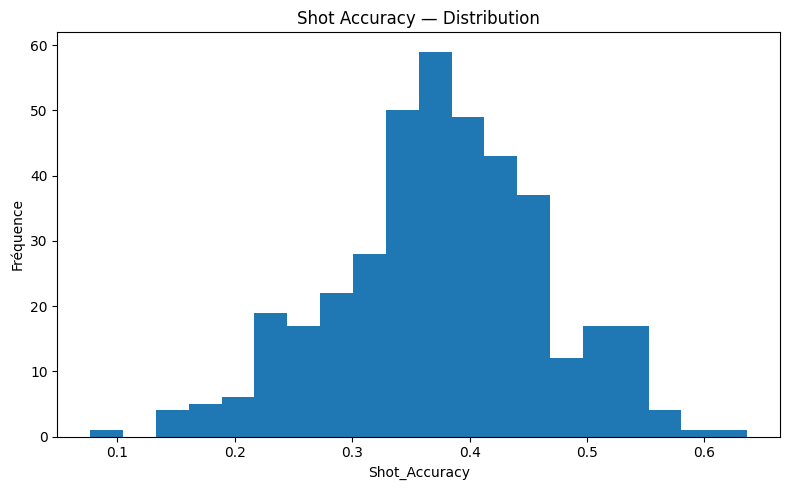

In [7]:
base['Shot_Accuracy'] = base['SoT'] / base['Sh_shooting']
hist_plot(base['Shot_Accuracy'], title='Shot Accuracy — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Shot_Conversion
**Pourquoi**: Efficacité au tir.

**Formule**: `Gls / Sh`

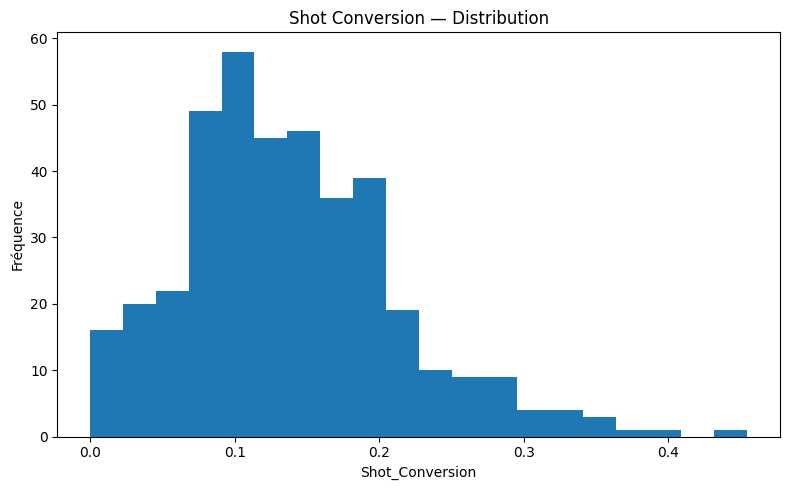

In [8]:
base['Shot_Conversion'] = base['Gls'] / base['Sh_shooting']
hist_plot(base['Shot_Conversion'], title='Shot Conversion — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : npxG_per_Shot
**Pourquoi**: Qualité moyenne des tirs.

**Formule**: `npxG / Sh`

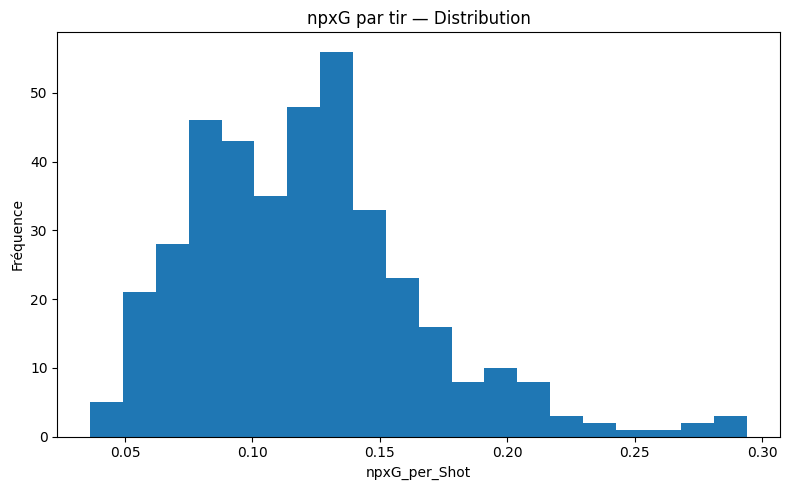

In [9]:
base['npxG_per_Shot'] = base['npxG'] / base['Sh_shooting']
hist_plot(base['npxG_per_Shot'], title='npxG par tir — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Box_Touches_per90
**Pourquoi**: Présence dans la surface.

**Formule**: `Att Pen_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


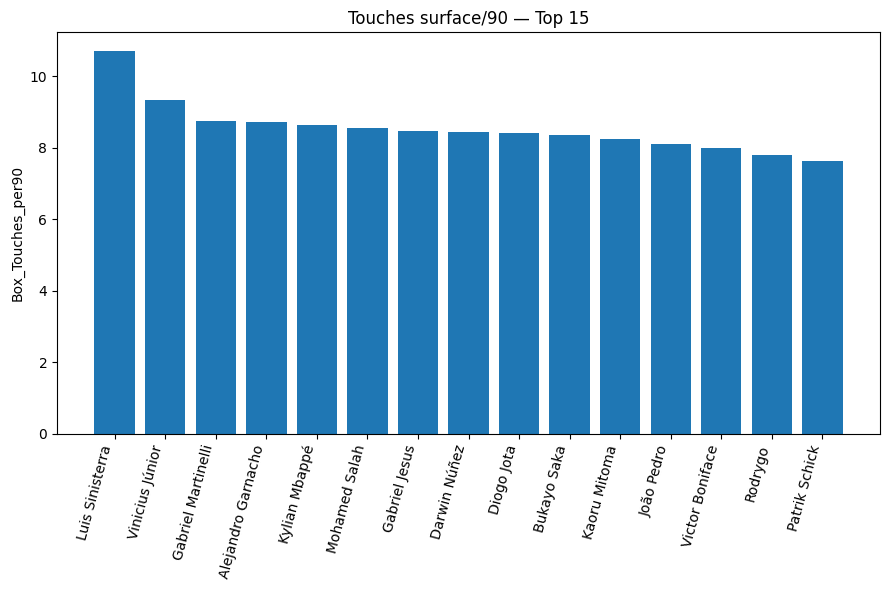

In [10]:
base['Box_Touches_per90'] = base.get('Att Pen_per_90', 0)
bar_top(base, 'Box_Touches_per90', title='Touches surface/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Box_Touch_Share
**Pourquoi**: Orientation vers la zone de but.

**Formule**: `Att Pen / Touches`

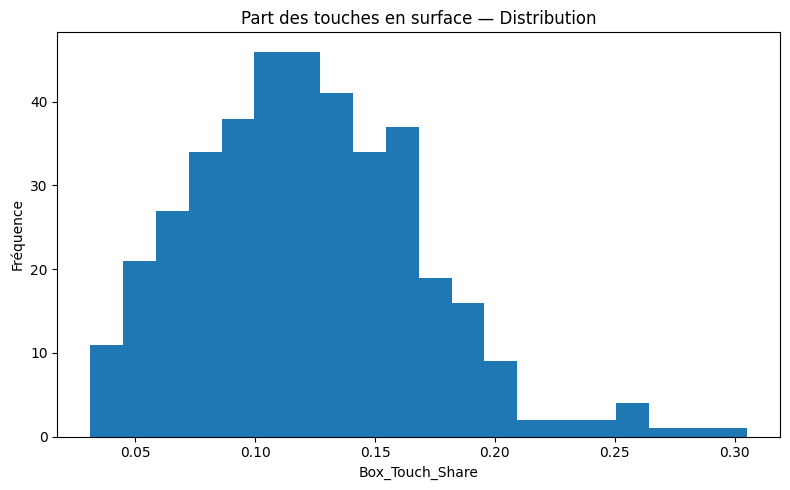

In [11]:
base['Box_Touch_Share'] = base.get('Att Pen', 0) / base.get('Touches', 1)
hist_plot(base['Box_Touch_Share'], title='Part des touches en surface — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Prog_Reception_per90
**Pourquoi**: Capacité à recevoir haut.

**Formule**: `PrgR_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


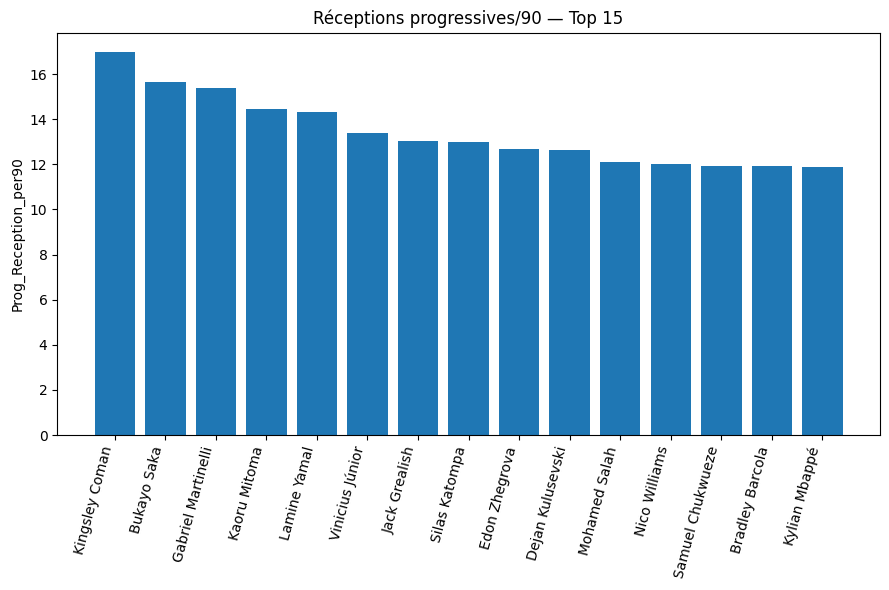

In [12]:
base['Prog_Reception_per90'] = base.get('PrgR_per_90', 0)
bar_top(base, 'Prog_Reception_per90', title='Réceptions progressives/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Prog_Carries_per90
**Pourquoi**: Menace balle au pied.

**Formule**: `PrgC_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


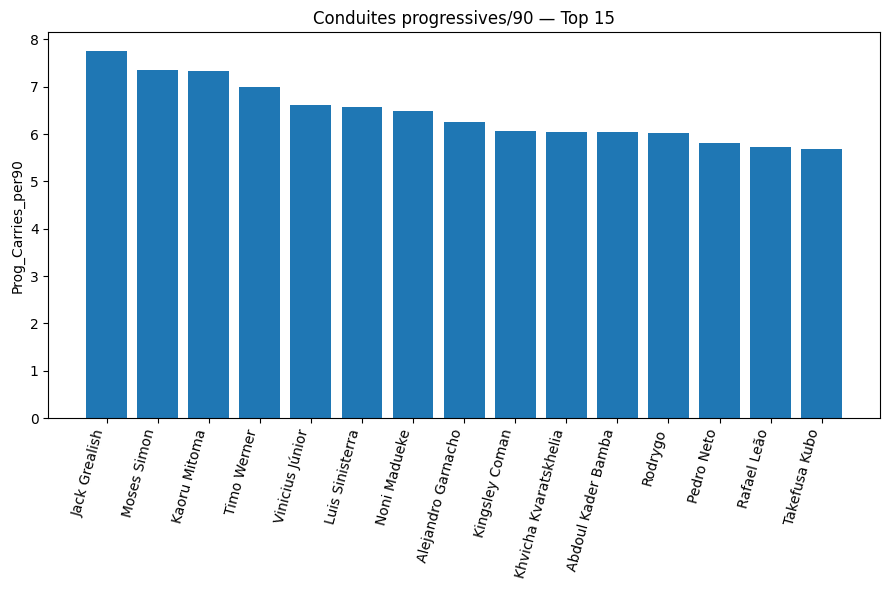

In [13]:
base['Prog_Carries_per90'] = base.get('PrgC_per_90', 0)
bar_top(base, 'Prog_Carries_per90', title='Conduites progressives/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Carries_into_Box_per90
**Pourquoi**: Pénétration surface.

**Formule**: `CPA_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


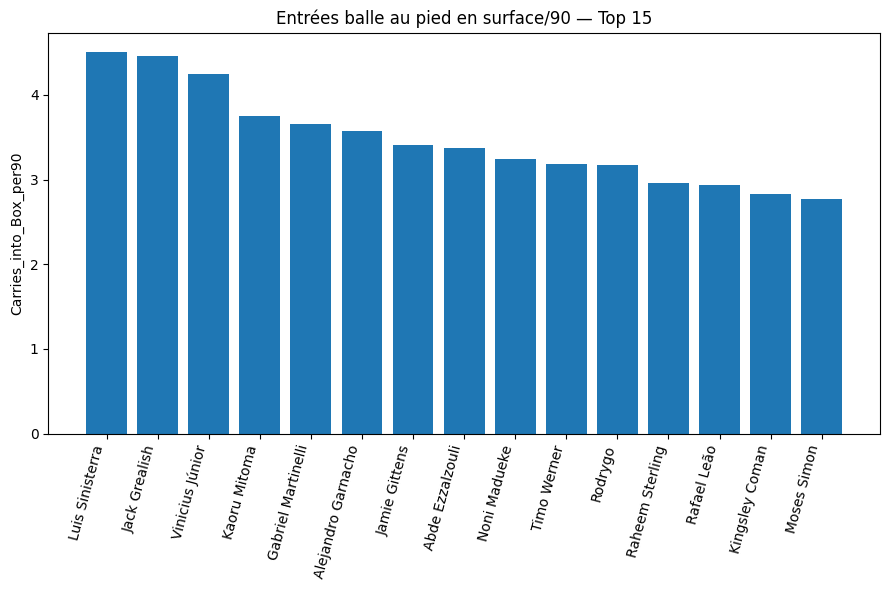

In [14]:
base['Carries_into_Box_per90'] = base.get('CPA_per_90', 0)
bar_top(base, 'Carries_into_Box_per90', title='Entrées balle au pied en surface/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Crosses_into_Box_per90
**Pourquoi**: Centres dangereux.

**Formule**: `CrsPA_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


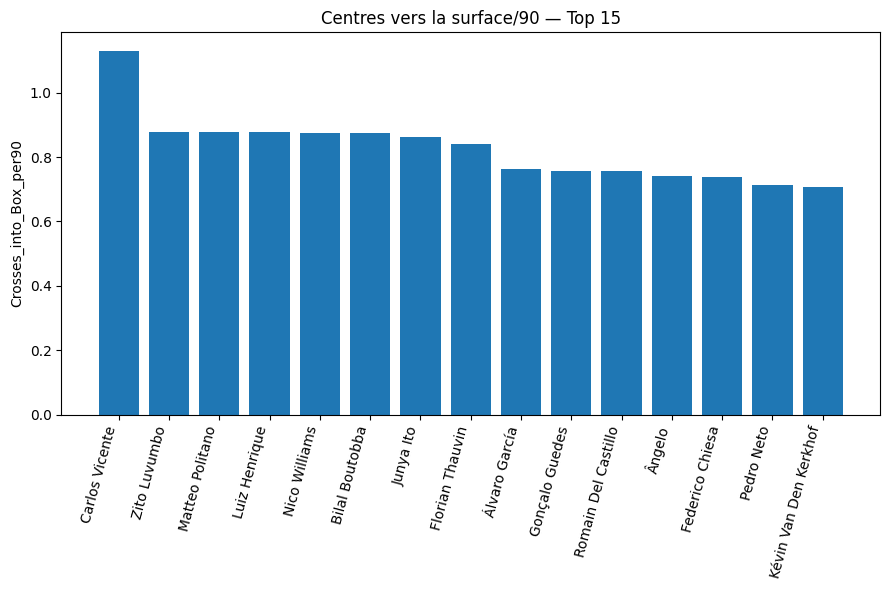

In [15]:
base['Crosses_into_Box_per90'] = base.get('CrsPA_per_90', 0)
bar_top(base, 'Crosses_into_Box_per90', title='Centres vers la surface/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : xGI_per90
**Pourquoi**: Menace offensive totale attendue.

**Formule**: `xG_per_90 + xAG_per_90`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


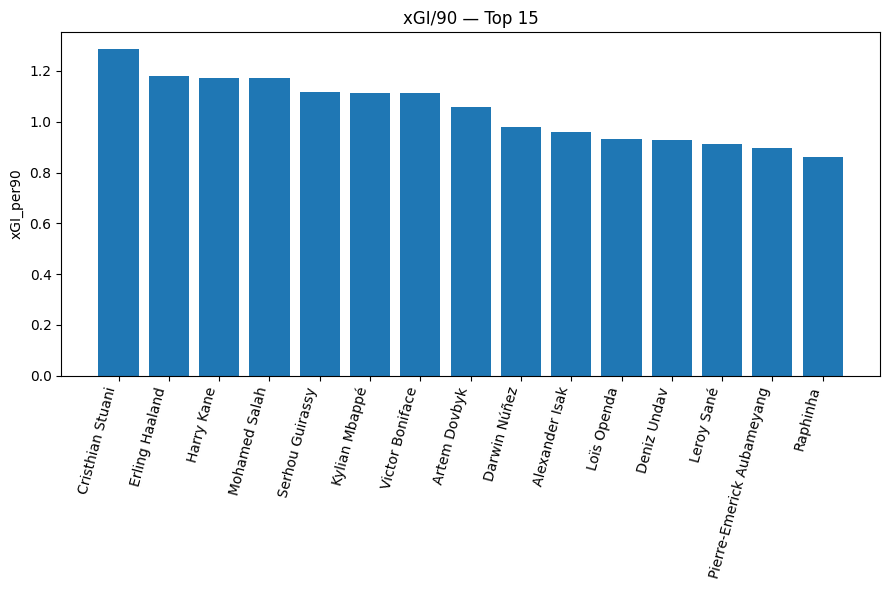

In [16]:
base['xGI_per90'] = base.get('xG_per_90', 0) + base.get('xAG_per_90', 0)
bar_top(base, 'xGI_per90', title='xGI/90 — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : A_minus_xAG_per90
**Pourquoi**: Sur/sous-conversion des receveurs.

**Formule**: `A-xAG_per_90`

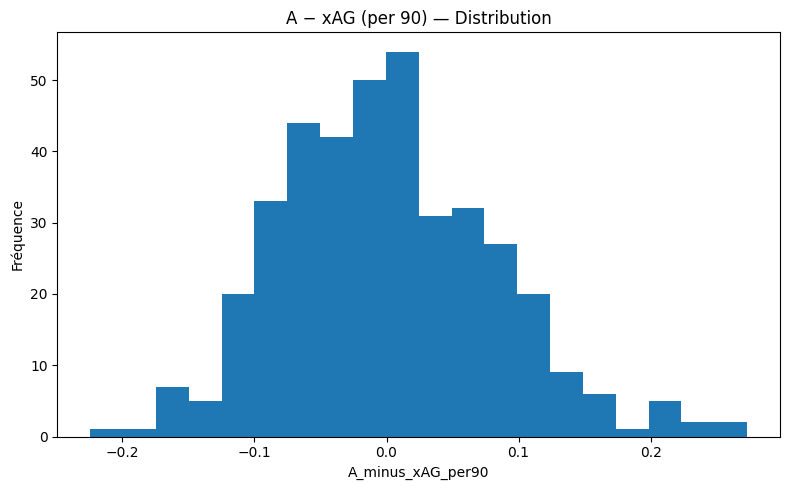

In [17]:
base['A_minus_xAG_per90'] = base.get('A-xAG_per_90', 0)
hist_plot(base['A_minus_xAG_per90'], title='A − xAG (per 90) — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : Shots_per_BoxTouch
**Pourquoi**: Agressivité dans la surface.

**Formule**: `Sh / Att Pen`

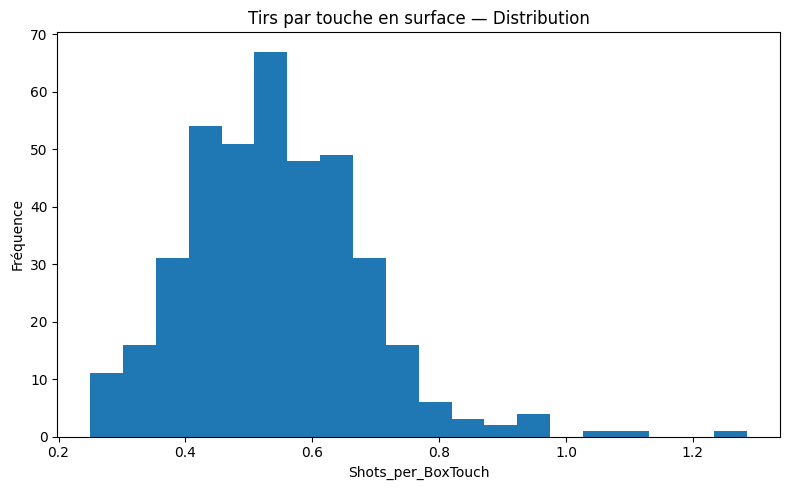

In [18]:
base['Shots_per_BoxTouch'] = base['Sh_shooting'] / base.get('Att Pen', 1)
hist_plot(base['Shots_per_BoxTouch'], title='Tirs par touche en surface — Distribution')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

### KPI : GA_minus_xGA_np_per90
**Pourquoi**: Durabilité probable de la production hors pénos.

**Formule**: `RealGA_np/90 − (npxG/90 + xAG/90)`

/var/folders/4j/jfg4lwbs1hg2xpm5_rw2qjcm0000gn/T/ipykernel_58451/4252449327.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(t['Player'], rotation=75, ha='right')


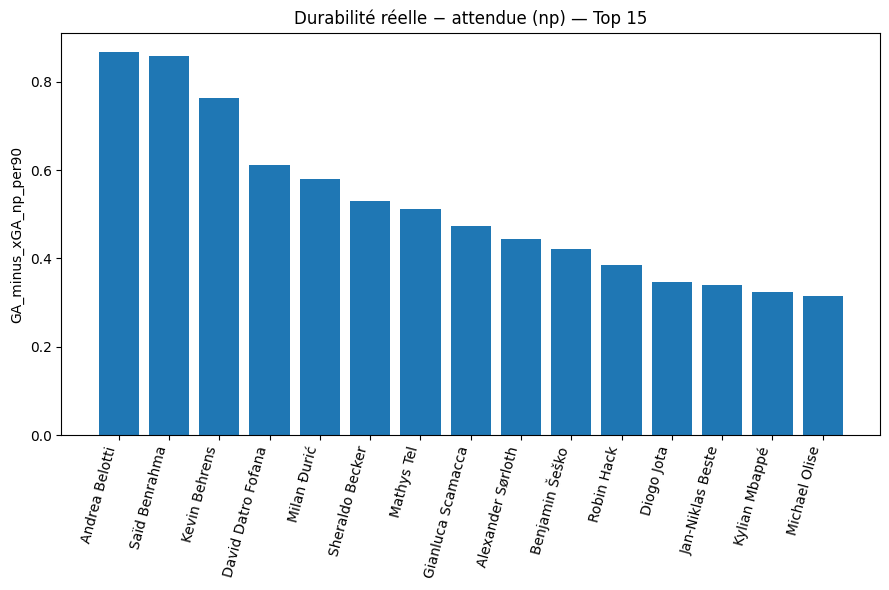

In [19]:
if 'G+A-PK_per_90' in base.columns:
    base['RealGA_np_per90'] = base['G+A-PK_per_90']
else:
    base['RealGA_np_per90'] = (base['Gls'] + base['Ast'] - base.get('PK',0)) / base['90s']
base['xGA_np_per90'] = base.get('npxG_per_90', 0) + base.get('xAG_per_90', 0)
base['GA_minus_xGA_np_per90'] = base['RealGA_np_per90'] - base['xGA_np_per90']
bar_top(base, 'GA_minus_xGA_np_per90', title='Durabilité réelle − attendue (np) — Top 15')

**Interprétation**: valeurs élevées ⇒ meilleure performance pour ce KPI. Toujours croiser avec rôle et minutes.

## 3. Colonnes personnalisées
Résumé des principales colonnes créées dans ce notebook.

In [20]:
custom_desc = {
    "npG": "Buts hors pénalty = Gls − PK",
    "npG_per90": "npG ramené à 90 minutes",
    "Shot_Accuracy": "SoT / Sh_shooting",
    "Shot_Conversion": "Gls / Sh_shooting",
    "npxG_per_Shot": "npxG / Sh_shooting",
    "Finishing_Delta_np": "(Gls − PK) − npxG",
    "Finishing_Ratio_np": "(Gls − PK) / npxG",
    "Box_Touches_per90": "Att Pen_per_90",
    "Box_Touch_Share": "Att Pen / Touches",
    "Prog_Reception_per90": "PrgR_per_90",
    "Prog_Carries_per90": "PrgC_per_90",
    "Prog_Passes_per90": "PrgP_per_90",
    "Carries_into_Box_per90": "CPA_per_90",
    "Crosses_into_Box_per90": "CrsPA_per_90",
    "xGI_per90": "xG_per_90 + xAG_per_90",
    "A_minus_xAG_per90": "A-xAG_per_90",
    "Shots_per_BoxTouch": "Sh_shooting / Att Pen",
    "RealGA_np_per90": "(Gls + Ast − PK) / 90s si G+A-PK absente",
    "xGA_np_per90": "npxG_per_90 + xAG_per_90",
    "GA_minus_xGA_np_per90": "RealGA_np_per90 − xGA_np_per90"
}
import pandas as pd
pd.DataFrame([{"Colonne":k, "Définition":v} for k,v in custom_desc.items()])

,Colonne,Définition
0,npG,Buts hors pénalty = Gls − PK
1,npG_per90,npG ramené à 90 minutes
2,Shot_Accuracy,SoT / Sh_shooting
3,Shot_Conversion,Gls / Sh_shooting
4,npxG_per_Shot,npxG / Sh_shooting
5,Finishing_Delta_np,(Gls − PK) − npxG
6,Finishing_Ratio_np,(Gls − PK) / npxG
7,Box_Touches_per90,Att Pen_per_90
8,Box_Touch_Share,Att Pen / Touches
9,Prog_Reception_per90,PrgR_per_90


## 4. Conclusion
- Combiner quantité (xGI/90) et qualité (npxG/Shot, Finishing Δ).
- Filtrer par minutes pour robustesse.
- Interpréter par rôle: 9, ailier, deuxième attaquant.